In [68]:
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

In [69]:
if __name__ == "__main__":
    # For this tutorial, construct a global JAX rng key
    # But we don't want it when importing as a library
    rng = jax.random.PRNGKey(1)

In [70]:
def random_SSM(rng, N):
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return A, B, C

In [71]:
random_SSM(rng, 5)

(Array([[0.11888373, 0.02597141, 0.25442433, 0.03801537, 0.26417494],
        [0.06834555, 0.76109946, 0.6487949 , 0.3947618 , 0.49821746],
        [0.7629558 , 0.7416612 , 0.1261679 , 0.7579925 , 0.25363898],
        [0.85696733, 0.82389295, 0.81947005, 0.5853926 , 0.54250216],
        [0.35728765, 0.7542579 , 0.32637298, 0.85206413, 0.24110329]],      dtype=float32),
 Array([[0.79785824],
        [0.73702896],
        [0.4746939 ],
        [0.32407498],
        [0.84053826]], dtype=float32),
 Array([[0.34117317, 0.8346112 , 0.31955123, 0.50551903, 0.6800754 ]],      dtype=float32))

In [72]:
def discretize(A, B, C, step):
    I = np.eye(A.shape[0])
    BL = inv(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = (BL * step) @ B
    return Ab, Bb, C

In [73]:
def scan_SSM(Ab, Bb, Cb, u, x0, verbose=False):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k

        if verbose:
            jax.debug.print("Ab: {}", Ab)
            jax.debug.print("Bb: {}", Bb)
            jax.debug.print("x_k-1: {}", x_k_1)
            jax.debug.print("u_k: {}", u_k)
            jax.debug.print("x_k = Ab @ x_k_1 + Bb @ u_k: {}", x_k)
            jax.debug.print("y_k = Cb @ x_k: {}", y_k)
            jax.debug.print("---------")
        return x_k, y_k

    return jax.lax.scan(step, x0, u)

In [74]:
def run_SSM(A, B, C, u, verbose=True):
    L = u.shape[0]
    N = A.shape[0]
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)

    # Run recurrence
    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)), verbose=verbose)[1]

In [75]:
np.array([[1, 2], [3, 4]]) @ np.array([1, 2])

Array([ 5, 11], dtype=int32)

In [76]:
def K_conv(Ab, Bb, Cb, L):
    return np.array(
        [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
    )

In [77]:
A, B, C = random_SSM(rng, 20)
L = 1
Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)

K = K_conv(Ab, Bb, Cb, L=3)

In [78]:
K

Array([-1.2262875,  1.8903167, -4.297544 ], dtype=float32)

In [79]:
u = np.array([1, 2, 3, 4])

convolve(u, K, mode="full")

Array([ -1.2262875 ,  -0.56225824,  -4.195773  ,  -7.829288  ,
        -5.3313646 , -17.190176  ], dtype=float32)

In [80]:
ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
out = ud * Kd
np.fft.irfft(out)[: u.shape[0]]

Array([ 0.4235166, -1.3600439, -7.6374397, -5.894321 ], dtype=float32)

In [81]:
np.pad(u, (0, K.shape[0]))

Array([1, 2, 3, 4, 0, 0, 0], dtype=int32)

In [82]:
K, Kd

(Array([-1.2262875,  1.8903167, -4.297544 ], dtype=float32),
 Array([-3.633515 +0.j       ,  0.9085992+2.7118864j,
         2.2250307-3.707557j , -5.608879 -4.180133j ], dtype=complex64))

In [83]:
np.fft.rfft(np.pad(u, (0, K.shape[0])))

Array([10.        +0.j       , -2.0244584 -6.223982j ,
        0.34601068+2.4791214j,  0.1784479 -2.4219847j], dtype=complex64)

In [84]:
u, ud

(Array([1, 2, 3, 4], dtype=int32),
 Array([10.        +0.j       , -2.0244584 -6.223982j ,
         0.34601068+2.4791214j,  0.1784479 -2.4219847j], dtype=complex64))

In [85]:
def causal_convolution(u, K, nofft=False):
    if nofft:
        return convolve(u, K, mode="full")[: u.shape[0]] # removes the addition results when K slides off the end of u
    else:
        assert K.shape[0] == u.shape[0]
        ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
        out = ud * Kd
        return np.fft.irfft(out)[: u.shape[0]]

In [86]:
def test_cnn_is_rnn(N=4, L=16, step=1.0 / 16):
    ssm = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L,))
    jax.random.split(rng, 3)
    # RNN
    rec = run_SSM(*ssm, u, verbose=False)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = causal_convolution(u, K_conv(*ssmb, L))

    print("RNN:", rec)
    print("CNN:", conv)

    # Check
    assert np.allclose(rec.ravel(), conv.ravel())

test_cnn_is_rnn()

RNN: [[0.01893413]
 [0.02310157]
 [0.05276325]
 [0.08760231]
 [0.11060267]
 [0.14200173]
 [0.16301736]
 [0.19073845]
 [0.22022295]
 [0.25288185]
 [0.2983596 ]
 [0.345329  ]
 [0.42143378]
 [0.48412403]
 [0.55174446]
 [0.66502684]]
CNN: [0.01893416 0.02310163 0.05276331 0.08760233 0.11060268 0.14200175
 0.16301738 0.19073848 0.2202229  0.25288185 0.2983596  0.345329
 0.42143366 0.4841239  0.55174434 0.66502666]


## An SSM neural network

In [87]:
jax.random.uniform(rng, (2, 3))

Array([[0.83079386, 0.1660409 , 0.8430486 ],
       [0.6428884 , 0.56865394, 0.6144446 ]], dtype=float32)

In [122]:
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(key, shape):
        return jax.random.uniform(key, shape) * (
            np.log(dt_max) - np.log(dt_min)
        ) + np.log(dt_min)

    return init


def causal_convolution(u, K, nofft=False):
    if nofft:
        return convolve(u, K, mode="full")[: u.shape[0]] # removes the addition results when K slides off the end of u
    else:
        assert K.shape[0] == u.shape[0]
        ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
        out = ud * Kd
        return np.fft.irfft(out)[: u.shape[0]]

class SSMLayer(nn.Module):
    N: int # hidden state dimension
    l_max: int # max seq length
    decode: bool = False # Are we in the RNN mode?

    # THIS setup is called each time parameters are updated(?)
    def setup(self):

        # SSM parameters
        self.A = self.param("A", lecun_normal(), (self.N, self.N))
        self.B = self.param("B", lecun_normal(), (self.N, 1))
        self.C = self.param("C", lecun_normal(), (1, self.N))
        self.D = self.param("D", nn.initializers.ones, (1,))

        # Step parameter
        self.log_step = self.param("log_step", log_step_initializer(), (1,))

        step = np.exp(self.log_step)
        self.ssm = discretize(self.A, self.B, self.C, step=step)
        self.K = K_conv(*self.ssm, self.l_max)

        # RNN cache for long sequences
        self.x_k_1 = self.variable("cache", "cache_x_k", np.zeros, (self.N,))

    def __call__(self, u):
        if not self.decode:
            # CNN Mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN Mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u
        



class SequenceBlock(nn.Module):
    layer_cls: nn.Module
    layer: dict  # Hyperparameters of inner layer
    dropout: float
    d_model: int
    prenorm: bool = True
    glu: bool = True
    training: bool = True
    decode: bool = False

    def setup(self):
        self.seq = self.layer_cls(**self.layer, decode=self.decode)
        self.norm = nn.LayerNorm()
        self.out = nn.Dense(self.d_model)
        if self.glu:
            self.out2 = nn.Dense(self.d_model)
        self.drop = nn.Dropout(
            self.dropout,
            broadcast_dims=[0],
            deterministic=not self.training,
        )

    def __call__(self, x):
        skip = x
        if self.prenorm:
            x = self.norm(x)
        x = self.seq(x)
        x = self.drop(nn.gelu(x))
        if self.glu:
            x = self.out(x) * jax.nn.sigmoid(self.out2(x))
        else:
            x = self.out(x)
        x = skip + self.drop(x)
        if not self.prenorm:
            x = self.norm(x)
        return x


def cloneLayer(layer):
    """
    This will create 'embed dimension' number of copies of params A, B, C, step (D is just 1 in this case)
    Each embed dimension is treated as its own 1D sequence with its own A, B, C, step.

    For example sequence of length 3 with embed dim 2 would look like
    np.array([
        [1, 2, 3], 
        [2, 6, 10],
        [3, 7, 11],
    ])

    This is 3 independent sequences of length 3: [1, 2, 3], [2, 6, 10], [3, 7, 11]
    """
    return nn.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1},
        split_rngs={"params": True},
    )


class Embedding(nn.Embed):
    num_embeddings: int # size of vocab
    features: int # embed dimension

    @nn.compact
    def __call__(self, x):
        y = nn.Embed(num_embeddings=self.num_embeddings, features=self.features)(x[..., 0])
        return np.where(x > 0, y, 0.0)


class StackedModel(nn.Module):
    layer_cls: nn.Module
    layer: dict  # Extra arguments to pass into layer constructor
    d_output: int
    d_model: int
    n_layers: int
    prenorm: bool = True
    dropout: float = 0.0
    embedding: bool = False  # Use nn.Embed instead of nn.Dense encoder
    classification: bool = False
    training: bool = True
    decode: bool = False  # Probably should be moved into layer_args

    def setup(self):
        if self.embedding:
            self.encoder = Embedding(self.d_output, self.d_model)
        else:
            self.encoder = nn.Dense(self.d_model)
        self.decoder = nn.Dense(self.d_output)
        self.layers = [
            SequenceBlock(
                layer_cls=self.layer_cls,
                layer=self.layer,
                prenorm=self.prenorm,
                d_model=self.d_model,
                dropout=self.dropout,
                training=self.training,
                decode=self.decode,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        if not self.classification:
            if not self.embedding:
                x = x / 255.0  # Normalize
            if not self.decode:
                x = np.pad(x[:-1], [(1, 0), (0, 0)])
        x = self.encoder(x)
        for layer in self.layers:
            x = layer(x)
        if self.classification:
            x = np.mean(x, axis=0)
        x = self.decoder(x)
        return nn.log_softmax(x, axis=-1)
    
BatchStackedModel = nn.vmap(
    StackedModel,
    in_axes=0,
    out_axes=0,
    variable_axes={"params": None, "dropout": None, "cache": 0, "prime": None},
    # seet both to false means batch of two input sequences give identical outputs 
    split_rngs={"params": False, "dropout": True},
)


def make_HiPPO(N):
    P = np.sqrt(1 + 2 * np.arange(N))
    A = P[:, np.newaxis] * P[np.newaxis, :]
    A = np.tril(A) - np.diag(np.arange(N))
    return -A


## Hippo Matrix

In [124]:
make_HiPPO(5)

Array([[-1.       , -0.       , -0.       , -0.       , -0.       ],
       [-1.7320508, -2.       , -0.       , -0.       , -0.       ],
       [-2.236068 , -3.8729832, -3.       , -0.       , -0.       ],
       [-2.6457512, -4.5825753, -5.9160795, -3.9999995, -0.       ],
       [-3.       , -5.196152 , -6.7082043, -7.937254 , -5.       ]],      dtype=float32)

## BatchStackedModel layer init example

In [121]:
init_rng, dropout_rng = jax.random.split(rng, num=2)

SSMVmap = cloneLayer(SSMLayer)

stack = BatchStackedModel(
    layer_cls=SSMVmap,
    layer={"N": 6, "l_max": 5},
    dropout=0.1,
    d_model=4,
    d_output=5,
    n_layers=2,
    decode=False # if False requires dim of K is same length as input seq, i.e l_max = seq length
)

# A batch of two sequences of embeddings
# ncols, embed dim = d_model, nrows = seq length
x = np.array([
    # seq 1
    [[1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]],
    # seq 2 
    [[1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]],
])

o, p = stack.init_with_output({"params": init_rng, "dropout": dropout_rng}, x)

print("Input shape", x.shape)
print("Output shape", o.shape)
print("Output:", o)
tabulate_fn = nn.tabulate(stack, {"params": init_rng, "dropout": dropout_rng})
print(tabulate_fn(x))

Input shape (2, 5, 5)
Output shape (2, 5, 5)
Output: [[[-1.609438  -1.609438  -1.609438  -1.609438  -1.609438 ]
  [-2.3469849 -1.6016883 -1.0093875 -2.2912683 -1.4388237]
  [-2.3390398 -1.6000339 -1.0143468 -2.27979   -1.4407709]
  [-2.3321614 -1.598366  -1.0187337 -2.2694275 -1.4428031]
  [-2.3263168 -1.5966854 -1.0225577 -2.2601302 -1.4449086]]

 [[-1.609438  -1.609438  -1.609438  -1.609438  -1.609438 ]
  [-2.3469849 -1.6016883 -1.0093875 -2.2912683 -1.4388237]
  [-2.3390398 -1.6000339 -1.0143468 -2.27979   -1.4407709]
  [-2.3321614 -1.598366  -1.0187337 -2.2694275 -1.4428031]
  [-2.3263168 -1.5966854 -1.0225577 -2.2601302 -1.4449086]]]

                            VmapStackedModel Summary                            
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ params     ┃ cache       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│            │ VmapStack… │ 

## StackedModel layer init example

In [119]:
init_rng, dropout_rng = jax.random.split(rng, num=2)

SSMVmap = cloneLayer(SSMLayer)

stack = StackedModel(
    layer_cls=SSMVmap,
    layer={"N": 6, "l_max": 5},
    dropout=0.1,
    d_model=4,
    d_output=5,
    n_layers=2,
    decode=True
)

# A single sequence of embeddings
# ncols, embed dim = d_model, nrows = seq length
x = np.array([
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
])

o, p = stack.init_with_output({"params": init_rng, "dropout": dropout_rng}, x)

print("Input shape", x.shape)
print("Output shape", o.shape)
print("Output:", o)
tabulate_fn = nn.tabulate(stack, {"params": init_rng, "dropout": dropout_rng})
print(tabulate_fn(x))

Input shape (4, 5)
Output shape (4, 5)
Output: [[-2.3469849 -1.6016883 -1.0093875 -2.2912683 -1.4388237]
 [-2.3390398 -1.6000339 -1.0143468 -2.27979   -1.4407709]
 [-2.3321614 -1.598366  -1.0187337 -2.2694275 -1.4428031]
 [-2.3263168 -1.5966854 -1.0225577 -2.2601302 -1.4449086]]

                              StackedModel Summary                              
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ params     ┃ cache       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│            │ StackedMo… │ int32[4,5] │ float32[4… │            │             │
├────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ encoder    │ Dense      │ float32[4… │ float32[4… │ bias:      │             │
│            │            │            │            │ float32[4] │             │
│            │            │            │            │ kernel:    │     

## Embed layer init example

In [106]:
layer = Embedding(num_embeddings=5, features=3)
indices_input = np.array([[6],  [0], [1], [2], [-1], [3]])
output, params = layer.init_with_output(jax.random.PRNGKey(1), indices_input)

print(params)
print(output)

{'params': {'embedding': Array([[-0.5474848 , -0.48036295,  0.10160114],
       [ 0.5684244 , -0.3826952 , -0.9501267 ],
       [-0.7158868 , -0.3815823 , -0.03696465],
       [ 0.32678705,  0.9207937 , -0.5220883 ],
       [-0.22882082, -0.6123475 , -0.67258674]], dtype=float32), 'Embed_0': {'embedding': Array([[-0.5431886 ,  0.223633  , -1.0188975 ],
       [ 0.9756091 , -0.47169256,  0.10822168],
       [-0.37928337,  0.5580153 , -0.26732865],
       [-0.63215506,  0.37527135, -0.26105613],
       [ 0.5191519 , -0.51038426,  0.08034096]], dtype=float32)}}}
[[        nan         nan         nan]
 [ 0.          0.          0.        ]
 [ 0.9756091  -0.47169256  0.10822168]
 [-0.37928337  0.5580153  -0.26732865]
 [ 0.          0.          0.        ]
 [-0.63215506  0.37527135 -0.26105613]]


Base Embed module example

In [89]:
import flax.linen as nn
import jax, jax.numpy as jnp

layer = nn.Embed(num_embeddings=5, features=3)
indices_input = jnp.array([[0], [-1]])
variables = layer.init(jax.random.PRNGKey(1), indices_input)
variables

{'params': {'embedding': Array([[-0.5474848 , -0.48036295,  0.10160114],
         [ 0.5684244 , -0.3826952 , -0.9501267 ],
         [-0.7158868 , -0.3815823 , -0.03696465],
         [ 0.32678705,  0.9207937 , -0.5220883 ],
         [-0.22882082, -0.6123475 , -0.67258674]], dtype=float32)}}

## Seq block Layer init example 

In [102]:
init_rng, dropout_rng = jax.random.split(rng, num=2)
SSMVmap = cloneLayer(SSMLayer)

# d_model, must match embedding dimenstion for (skip + x) to work.  (L * embed dim) + (L * d_model)
seq = SequenceBlock(
    layer_cls=SSMVmap,
    layer={"N": 6, "l_max": 5},
    dropout=0.1,
    d_model=4,
    decode=False
    # training=False
)

# A single sequence of embeddings
# ncols, embed dim = d_model, nrows = seq length
x = np.array([
    [1, 2, 3,  10], 
    [2, 6, 10, 10],
    [3, 7, 11, 10],
    [4, 7, 11, 10],
    [4, 7, 10, 11]
])

o, p = seq.init_with_output({"params": init_rng, "dropout": dropout_rng}, x)

print("Input shape", x.shape)
print("Output shape", o.shape)
tabulate_fn = nn.tabulate(seq, {"params": init_rng, "dropout": dropout_rng})
print(tabulate_fn(x))

Input shape (5, 4)
Output shape (5, 4)

                             SequenceBlock Summary                              
┏━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path ┃ module      ┃ inputs       ┃ outputs     ┃ params       ┃ cache       ┃
┡━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│      │ SequenceBl… │ int32[5,4]   │ float32[5,… │              │             │
├──────┼─────────────┼──────────────┼─────────────┼──────────────┼─────────────┤
│ norm │ LayerNorm   │ int32[5,4]   │ float32[5,… │ bias:        │             │
│      │             │              │             │ float32[4]   │             │
│      │             │              │             │ scale:       │             │
│      │             │              │             │ float32[4]   │             │
│      │             │              │             │              │             │
│      │             │              │             │ 8 (32 B)     │   

## SSM Layer init example 

In [95]:
SSMVmap = cloneLayer(SSMLayer)


# Dim of K is l_max x l_max, for decode=False need u.shape[0] == K.shape[0] == l_max
s1 = SSMLayer(N=12, l_max=5, decode=False)
s2 = SSMVmap(N=12, l_max=5, decode=False)

# Init done WITH dummy input data for shape inference
# Basic 1D version
x1 = np.array(
    [1, 2, 3, 4, 5]
)
o1, p1 = s1.init_with_output(jax.random.PRNGKey(1), x1)

# V mapped verison
# ncols, embed dim = d_model, nrows = seq length
x2 = np.array([
    [1, 2, 3], 
    [2, 6, 10],
    [3, 7, 11],
    [4, 7, 11],
    [4, 7, 11]
])
o2, p2 = s2.init_with_output(jax.random.PRNGKey(1), x2)
print("----")
print(s1.apply(p1, x1))
print(s2.apply(p2, x2))

tabulate_fn = nn.tabulate(SSMVmap(N=12, l_max=5, decode=False), jax.random.PRNGKey(1), compute_flops=True, compute_vjp_flops=True)
print(tabulate_fn(x2))

----
[1.0578151 2.175106  3.3536835 4.59551   5.9027014]
[[ 0.9848459  1.9725535  2.9852316]
 [ 1.954891   5.8906164  9.936184 ]
 [ 2.9104915  6.7961617 10.882811 ]
 [ 3.8520064  6.7031116 10.830082 ]
 [ 3.7949517  6.611464  10.777983 ]]


/Users/felix/Documents/learning/annotated_s4/venv/lib/python3.8/site-packages/flax/core/lift.py:137: RuntimeWarning: kwargs are not supported in vmap, so "compute_flops, compute_vjp_flops" is(are) ignored
  warnings.warn(msg.format(name, ', '.join(kwargs.keys())), RuntimeWarning)



                              VmapSSMLayer Summary                              
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path ┃ module       ┃ inputs   ┃ outputs    ┃ params         ┃ cache         ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│      │ VmapSSMLayer │ int32[]  │ int32[]    │ A:             │ cache_x_k:    │
│      │              │          │            │ float32[12,3,… │ float32[12,3] │
│      │              │          │            │ B:             │               │
│      │              │          │            │ float32[12,3,… │ 36 (144 B)    │
│      │              │          │            │ C:             │               │
│      │              │          │            │ float32[1,3,1… │               │
│      │              │          │            │ D:             │               │
│      │              │          │            │ float32[1,3]   │               │
│      │              │    

Simple vmap example 

In [ ]:
def func(x, y):
    return x + y

func_vmap =jax.vmap(
    func
    , in_axes=1, out_axes=1
)

for x, y in np.array([[1, 2, 3], [4, 5, 6]]), np.array([[1,2,3], [4, 5, 6]]):
    print(func(x, y))

func_vmap(np.array([[1, 2, 3], [4, 5, 6]]), np.array([[1,2,3], [4, 5, 6]]))

[5 7 9]
[5 7 9]


ValueError: vmap was requested to map its argument along axis 2, which implies that its rank should be at least 3, but is only 2 (its shape is (2, 3))

# Mechanics example



In [ ]:
np.arange(10)

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

Ab: [[ 0.9980507   0.00974659]
 [-0.38986352  0.94931775]]
Bb: [[4.8732938e-05]
 [9.7465878e-03]]
x_k-1: [0. 0.]
u_k: [0.]
x_k = Ab @ x_k_1 + Bb @ u_k: [0. 0.]
y_k = Cb @ x_k: [0.]
---------
Ab: [[ 0.9980507   0.00974659]
 [-0.38986352  0.94931775]]
Bb: [[4.8732938e-05]
 [9.7465878e-03]]
x_k-1: [0. 0.]
u_k: [0.]
x_k = Ab @ x_k_1 + Bb @ u_k: [0. 0.]
y_k = Cb @ x_k: [0.]
---------
Ab: [[ 0.9980507   0.00974659]
 [-0.38986352  0.94931775]]
Bb: [[4.8732938e-05]
 [9.7465878e-03]]
x_k-1: [0. 0.]
u_k: [0.]
x_k = Ab @ x_k_1 + Bb @ u_k: [0. 0.]
y_k = Cb @ x_k: [0.]
---------
Ab: [[ 0.9980507   0.00974659]
 [-0.38986352  0.94931775]]
Bb: [[4.8732938e-05]
 [9.7465878e-03]]
x_k-1: [0. 0.]
u_k: [0.]
x_k = Ab @ x_k_1 + Bb @ u_k: [0. 0.]
y_k = Cb @ x_k: [0.]
---------
Ab: [[ 0.9980507   0.00974659]
 [-0.38986352  0.94931775]]
Bb: [[4.8732938e-05]
 [9.7465878e-03]]
x_k-1: [0. 0.]
u_k: [0.]
x_k = Ab @ x_k_1 + Bb @ u_k: [0. 0.]
y_k = Cb @ x_k: [0.]
---------
Ab: [[ 0.9980507   0.00974659]
 [-0.38986352 

MovieWriter imagemagick unavailable; using Pillow instead.


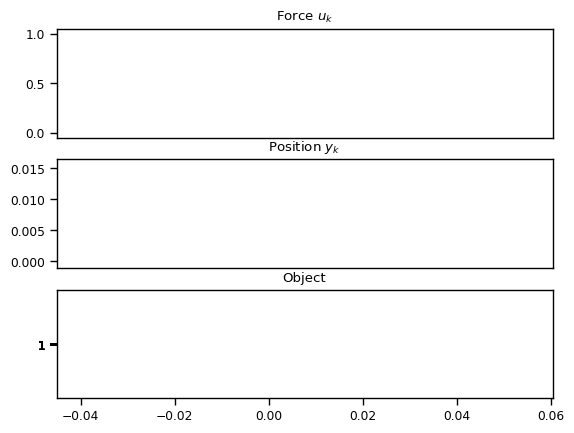

In [ ]:
def example_mass(k, b, m):
    A = np.array([[0, 1], [-k / m, -b / m]])
    B = np.array([[0], [1.0 / m]])
    C = np.array([[1.0, 0]])
    return A, B, C


@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return x * (x > 0.5)

def example_ssm():
    # SSM
    A, B, C = example_mass(k=40, b=5, m=1)

    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(A, B, C, u, versbose=True)

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("images/line.gif", dpi=150, writer="imagemagick")

if False:
    pass

example_ssm()


In [ ]:
A, B, C = random_SSM(rng, 2)
u = jax.random.normal(rng, (10, 2))

L = u.shape[0]
N = A.shape[0]
Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)

scan_SSM(Ab, Bb, Cb, u, np.zeros((N, 2)), verbose = True)[1]

Ab: [[1.1005622  0.02939623]
 [0.01520219 1.0882788 ]]
Bb: [[0.05516877 0.0520453 ]
 [0.08508889 0.08139773]]
x_k-1: [[0. 0.]
 [0. 0.]]
u_k: [-0.9859176 -1.0066605]
x_k = Ab @ x_k_1 + Bb @ u_k: [[-0.10678381 -0.16583051]
 [-0.10678381 -0.16583051]]
y_k = Cb @ x_k: [[-0.10546135 -0.1637768 ]]
---------
Ab: [[1.1005622  0.02939623]
 [0.01520219 1.0882788 ]]
Bb: [[0.05516877 0.0520453 ]
 [0.08508889 0.08139773]]
x_k-1: [[-0.10678381 -0.16583051]
 [-0.10678381 -0.16583051]]
u_k: [-0.2213709 -1.3452404]
x_k = Ab @ x_k_1 + Bb @ u_k: [[-0.20288746 -0.31571728]
 [-0.2000601  -0.3113265 ]]
y_k = Cb @ x_k: [[-0.198991   -0.30965832]]
---------
Ab: [[1.1005622  0.02939623]
 [0.01520219 1.0882788 ]]
Bb: [[0.05516877 0.0520453 ]
 [0.08508889 0.08139773]]
x_k-1: [[-0.20288746 -0.31571728]
 [-0.2000601  -0.3113265 ]]
u_k: [ 0.74275523 -2.1406245 ]
x_k = Ab @ x_k_1 + Bb @ u_k: [[-0.29960382 -0.46766007]
 [-0.29123804 -0.4546514 ]]
y_k = Cb @ x_k: [[-0.29179892 -0.4555015 ]]
---------
Ab: [[1.1005622  

Array([[[-0.10546135, -0.1637768 ]],

       [[-0.198991  , -0.30965832]],

       [[-0.29179892, -0.4555015 ]],

       [[-0.3652196 , -0.5694511 ]],

       [[-0.4375375 , -0.6821023 ]],

       [[-0.6655019 , -1.0367116 ]],

       [[-0.6420449 , -1.0014658 ]],

       [[-0.84966177, -1.3237844 ]],

       [[-0.9118697 , -1.4214988 ]],

       [[-1.0158188 , -1.5841626 ]]], dtype=float32)